# overview of campaign deployments: taos2-drifters0 + taos2-drifters1

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

import pynsitu as pin
crs=pin.maps.crs

In [2]:
## taos

taos = "taos2"

root_dir = f"/Users/aponte/Current_Projects/taos/campagnes/{taos}/"
cp0 = pin.Campaign(os.path.join(root_dir,f"drifters0/{taos}_drifters0.yaml"))
cp1 = pin.Campaign(os.path.join(root_dir,f"drifters1/{taos}_drifters1.yaml"))
C = {taos+"_drifters0": cp0, taos+"_drifters1": cp1}


# plot all deployments
for c, cp in C.items():

    print(f"-----  {c} ")
    for label, deployment, platform, sensor, meta in cp.get_all_deployments():
        print(platform, sensor, deployment)

-----  taos2_drifters0 
None None day0 / start 2023-05-05 07:00:00 / end 2023-05-05 20:00:00
hydrophone None d0 / start 2023-05-05 07:55:00 / end 2023-05-05 11:23:00
hydrophone None d1 / start 2023-05-09 09:16:00 / end 2023-05-09 13:31:00
hydrophone None d2 / start 2023-05-11 10:32:00 / end 2023-05-11 13:35:00
hydrophone ctd s0 / start 2023-05-05 08:17:40 / end 2023-05-05 08:21:40
hydrophone ctd s1 / start 2023-05-05 08:25:10 / end 2023-05-05 08:27:00
hydrophone ctd s2 / start 2023-05-05 08:30:50 / end 2023-05-05 08:32:50
hydrophone ctd s3 / start 2023-05-05 08:37:00 / end 2023-05-05 08:40:40
hydrophone ctd s4 / start 2023-05-05 08:45:10 / end 2023-05-05 08:47:50
hydrophone ctd s5 / start 2023-05-05 08:53:00 / end 2023-05-05 08:54:00
hydrophone ctd s6 / start 2023-05-05 08:59:00 / end 2023-05-05 09:02:00
hydrophone ctd s7 / start 2023-05-05 09:06:00 / end 2023-05-05 09:09:00
hydrophone ctd s8 / start 2023-05-05 09:17:10 / end 2023-05-05 09:18:40
hydrophone ctd c0 / start 2023-05-05 09:

In [3]:
root_dir_other = "/Users/aponte/Current_Projects/taos/campagnes/other/"
cpo = pin.Campaign(os.path.join(root_dir_other, "taos_other.yaml"))

nc = cpo.platforms["tide_gauge_ouistreham"]["files"]
tid = xr.open_dataset(nc)
tid = tid.sel(time=slice("2023/05/01", "2023/07/01")) 
#.to_frame()
#dst = cpo.load("tide_gauge_ouistreham.nc",  toframe=True)

In [4]:
D, S, W, Slvl = (dict() for _ in range(4))

def load_platform_deployments(p):
    return pd.concat([cp.load(f'{p}_{d}.nc', toframe=True) for d in cp[p].deployments()])


for c, cp in C.items():

    D[c] = cp.load('drifters.nc', toframe=True)

    #S[c] = dict(ship_hydrophone=load_platform_deployments('hydrophone'),
    #            ship_parceque=load_platform_deployments('parceque'),
    #           )
    
    try:
        W[c] = cp.load("arome.nc")
    except:
        W[c] = cp.load("arome.zarr")
    #Slvl[c] = cp.load('sea_level.nc', toframe=True)
    Slvl[c] = tid.to_dataframe()

---

## individual campaign overview

(19481.662500000002, 19489.212499999998)

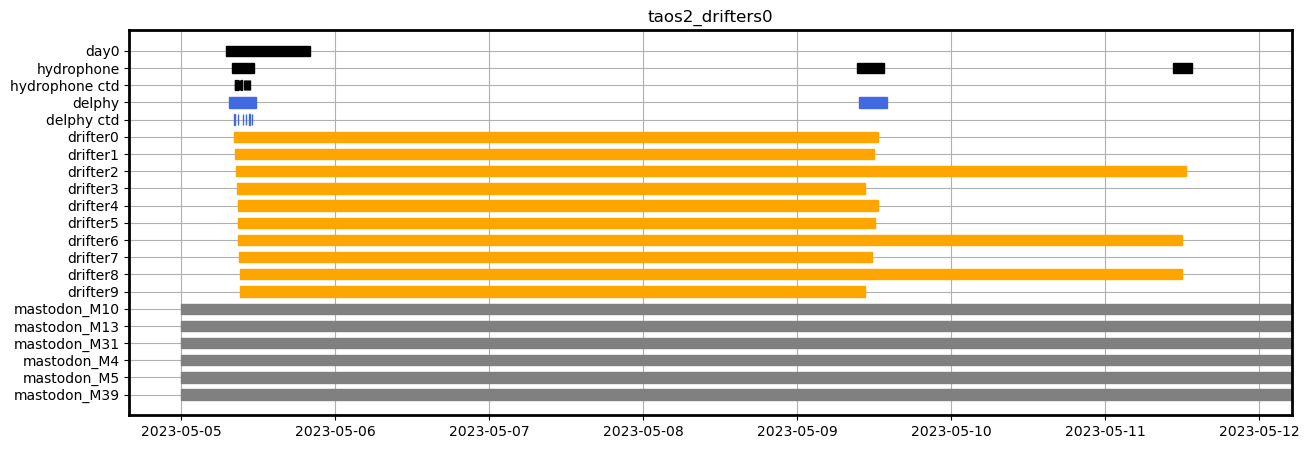

In [5]:
ax = C[taos+"_drifters0"].timeline()

date2num = pin.events.mdates.date2num
start, end = date2num(C[taos+"_drifters0"]["start"]), date2num(C[taos+"_drifters0"]["end"])
dt = (end - start)*.1

ax.set_xlim(start-dt, end+dt)

(19520.309375, 19523.68020833333)

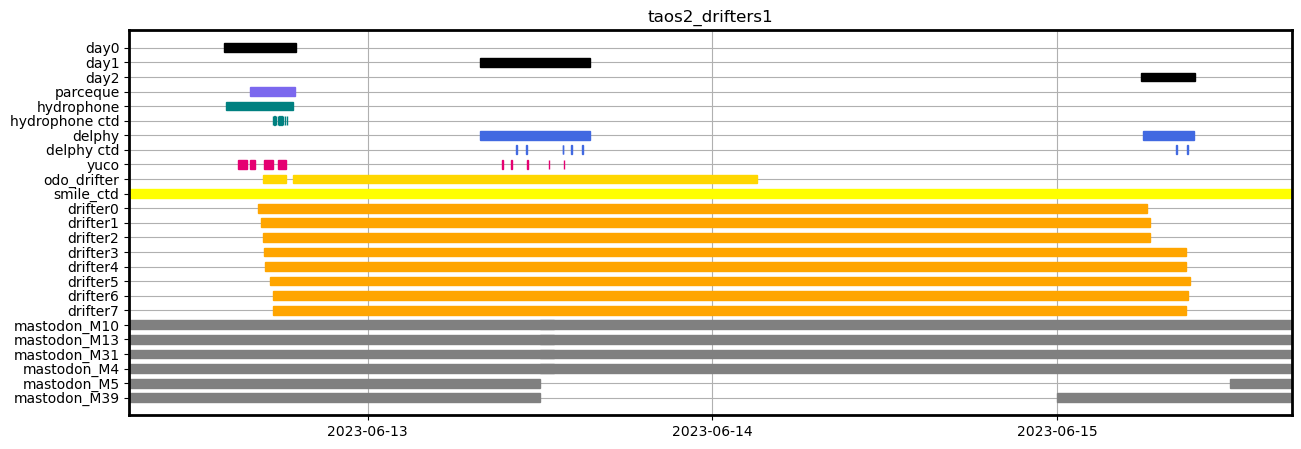

In [6]:
ax = C[taos+"_drifters1"].timeline()

date2num = pin.events.mdates.date2num
start, end = date2num(C[taos+"_drifters1"]["start"]), date2num(C[taos+"_drifters1"]["end"])
dt = (end - start)*.1

ax.set_xlim(start-dt, end+dt)

--- 
### Plot overview of both campaigns along with sea level and wind

In [7]:
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

def plot_combined_deployments(wind_stress=True, quiver_scale=None):

    fig, axes = plt.subplots(3,1, figsize=(10,7))

    height=10
    y=0
    starts, ends = [], []

    ax = axes[0]

    for c, cp in C.items():

        start = mdates.date2num(cp["start"])
        end = mdates.date2num(cp["end"])
        rect = Rectangle((start, y-height/2.), end-start, height,
                         color="orange")
        ax.add_patch(rect)
        starts.append(start)
        ends.append(end)
        #print(start, end-start)
        ax.text(start, y+height*0.4, c)

    # sea level
    _mtime = Slvl[c].index.map(lambda t: mdates.date2num(t))
    #_slvl = Slvl[c].sea_level.values
    #ax.plot(_mtime, _slvl, color="k", label="sea level")
    _slvl = (Slvl[c].sea_level -  Slvl[c].sea_level.mean()).values
    ax.plot(_mtime, _slvl, color="k", label="tidal sea level")

    delta_time = max(ends) - min(starts)

    def _set_axis(ax, xticklabels=True):

        ax.set_xlim(min(starts)-0.1*delta_time, max(ends)+0.1*delta_time)
        locator = mdates.AutoDateLocator(minticks=3)
        #formatter = mdates.AutoDateFormatter(locator)
        formatter = mdates.DateFormatter("%m-%d")
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        if not xticklabels:
            ax.set_xticklabels([])
        ax.grid()

    _set_axis(ax, xticklabels=False)
    ax.legend(loc='lower center')
    ax.set_ylabel("[m]")
    ax.set_ylim(-5,5)

    ### wind sticks
    ax = axes[1]

    # wind data
    #for w in W:
    w = W[list(W)[1]]
    _mtime = mdates.date2num(w.time)
    lon, lat = cp["drifter0"]["d0"].start.lon, cp["drifter0"]["d0"].start.lat
    _w = w.sel(longitude=lon, latitude=lat, method="nearest")
    _w_sub = _w.isel(time=slice(0,None,2))

    if wind_stress:
        scale = -3600 # s
        q = ax.quiver(_w_sub.time, _w_sub.ustress*0, 
                      _w_sub.ustress/scale, _w_sub.vstress/scale,
                      scale=quiver_scale,
                     )
        qk = ax.quiverkey(q, 0.8, 0.8, .2, r'$0.1\;Pa/m^2$', labelpos='E',
                           coordinates='axes')
    else:
        q = ax.quiver(_w_sub.time, _w_sub.u10m*0, 
                      _w_sub.u10m, _w_sub.v10m,
                      scale=quiver_scale,
                     )
        qk = ax.quiverkey(q, 0.8, 0.8, 10., r'$10\;m/s$', labelpos='E',
                           coordinates='axes')
    _set_axis(ax, xticklabels=False)
    
    ### wind strength
    ax = axes[2]
    
    if wind_stress:
        # wind stress
        _uvstress = np.sqrt(_w.ustress**2+_w.vstress**2)
        ax.plot(_mtime, _uvstress/scale, color="k", label="wind stress")
        ax.plot(_mtime, _w.ustress/scale, label="u stress")
        ax.plot(_mtime, _w.vstress/scale, label="v stress")
        ax.set_ylabel("[Pa]")
    else:
        # wind speed
        _uv10 = np.sqrt(_w.u10m**2+_w.v10m**2)
        ax.plot(_mtime, _uv10, color="k", label="wind speed")
        ax.plot(_mtime, _w.u10m, label="u")
        ax.plot(_mtime, _w.v10m, label="v")
        ax.set_ylabel("[m/s]")

    _set_axis(ax)
    ax.legend()


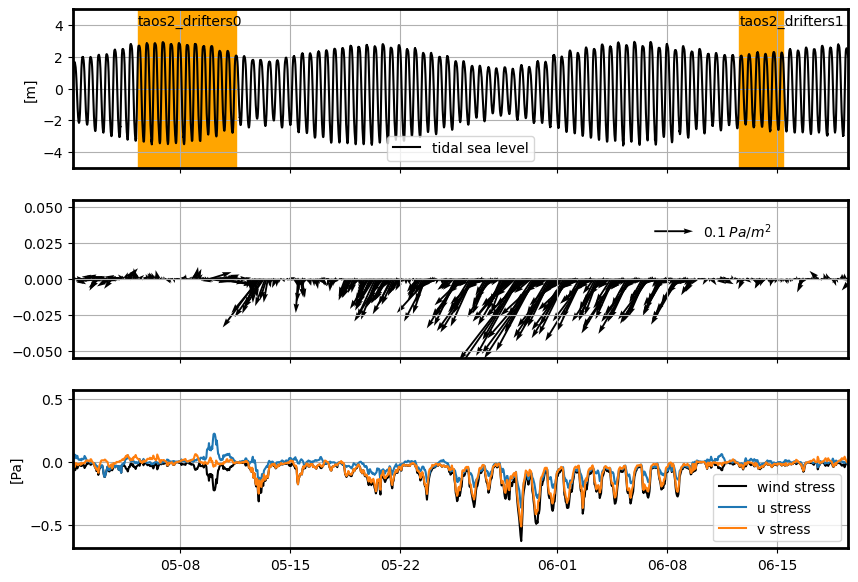

In [8]:
plot_combined_deployments(wind_stress=True, quiver_scale=4)

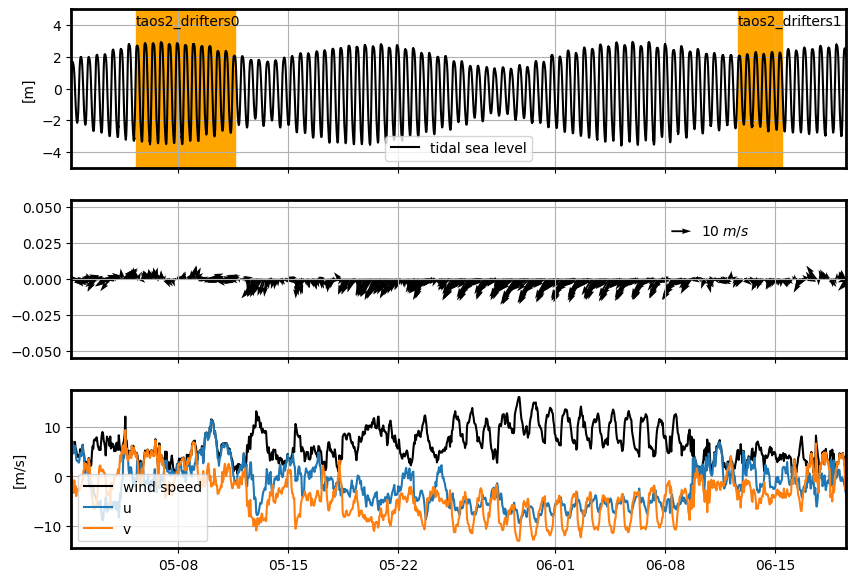

In [9]:
plot_combined_deployments(wind_stress=False)

---

## maps

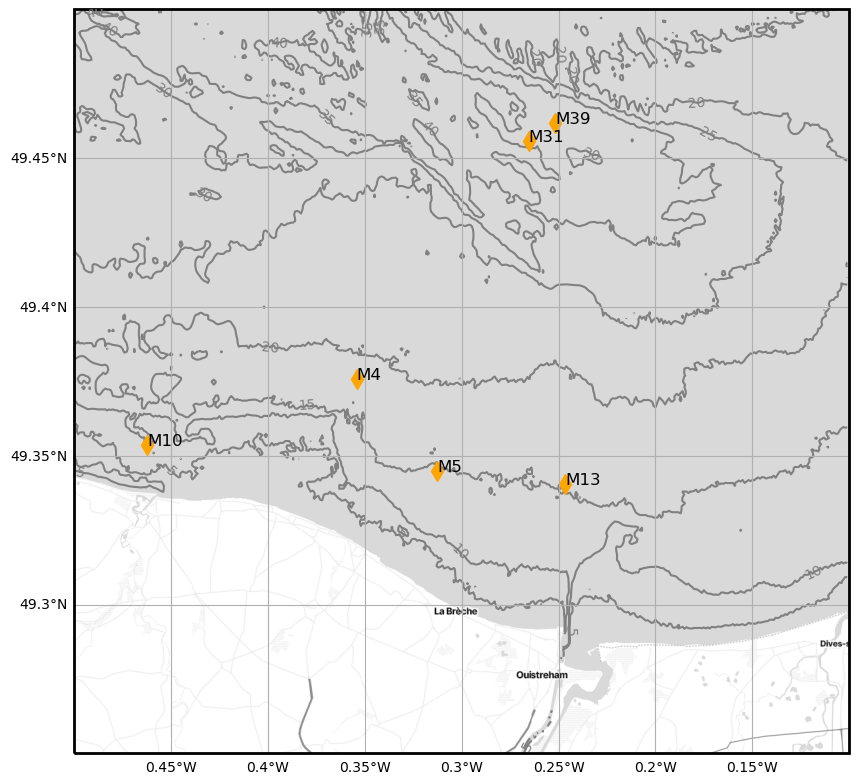

In [10]:
fig, ax, _ = cp.map(tile=("toner-lite",12), extent=(-0.5, -0.1, 49.25, 49.5), figsize=(10,10), land=False, coastline=False)

for p in cp.platforms:
    if "mastodon" in p:
        lon, lat = cp[p]["d0"].start.lon, cp[p]["d0"].start.lat,
        ax.plot(lon, lat, transform=crs, marker="d", markersize=10, color="orange") # cp[p]["color"]
        ax.text(lon, lat, p.split("_")[1], transform=crs, fontsize=12)